In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models import VGG19_Weights, vgg19
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF 
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import torch.optim as optim
import gc
from tqdm import tqdm
import pickle
import uuid
import math
import neptune

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Function to free up CUDA memory
def free_cuda_memory():
    torch.cuda.empty_cache()
    gc.collect()
free_cuda_memory()

In [4]:
# adding neptune.ai integration for logging metrics of run

#create a random runid for neptune.ai run
run_id = str(uuid.uuid4())

# initialize a new neptune.ai run
run = neptune.init_run(
    project="ImgResProject/ImageRes",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMDFiMjI3Zi1kZjQxLTQ0MjktYjU2My1iM2ZmMWUxNjM4MGMifQ==",
    tags=["SRGAN"],
    name="SRGAN-4"
)

# add the runid to neptune.ai id
run["id"] = run_id

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ImgResProject/ImageRes/e/FSRCNN-33


In [4]:
class SuperResolutionDataset(Dataset):
    def __init__(self, low_res_image_dir, high_res_image_dir, csv_file=None, image_data=None, transform=None):
        if image_data is not None:
            self.image_data = image_data
        elif csv_file is not None:
            self.image_data = pd.read_csv(csv_file)
        self.transform = transform
        self.csv_file = csv_file
        self.high_res_image_dir = high_res_image_dir+"/"
        self.low_res_image_dir = low_res_image_dir+"/"

        if len(self.image_data) == 0:
            raise ValueError(f"No image files found in CSV file: {csv_file}")
        
        print(f"Found {len(self.image_data)} image pairs.")

    def __len__(self):
        return len(self.image_data)
    
    def train_val_test_split(self, r1, r2, r3):
        assert r1 + r2 + r3 == 1, "Ratios must sum to 1"
        
        train_data, temp_data = train_test_split(self.image_data, test_size=(1 - r1))
        val_data, test_data = train_test_split(temp_data, test_size=(r3 / (r2 + r3)))
        
        train_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=train_data.reset_index(drop=True),
                                               transform=self.transform)
        
        val_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=val_data.reset_index(drop=True),
                                               transform=self.transform)
        
        test_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=test_data.reset_index(drop=True),
                                               transform=self.transform)
        
        return train_dataset, val_dataset, test_dataset

    def __getitem__(self, index):
        lr_image_path = self.image_data.iloc[index, 0]
        hr_image_path = self.image_data.iloc[index, 1]

        lr_img = Image.open(self.low_res_image_dir+lr_image_path).convert('RGB')
        hr_img = Image.open(self.high_res_image_dir+hr_image_path).convert('RGB')
        
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)
        return lr_img, hr_img

In [5]:
transform = transforms.Compose([
    # Convert images to tensors
    transforms.ToTensor(),
])
# Initialize the images dataset
low_res_dir = 'super_res2/low_res_images'
high_res_dir = 'super_res2/high_res_images'
csv_path = 'super_res2/super_res.csv'
img_dataset = SuperResolutionDataset(low_res_dir, high_res_dir,csv_file=csv_path, transform=transform)

Found 3762 image pairs.


In [6]:
#split the data into train, validation and test set
train_dataset, val_dataset, test_dataset = img_dataset.train_val_test_split(0.7, 0.15, 0.15)

Found 2633 image pairs.
Found 564 image pairs.
Found 565 image pairs.


In [7]:
# Print number of images in each split
print(f"Number of images in train set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

Number of images in train set: 2633
Number of images in validation set: 564
Number of images in test set: 565


In [8]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=4)

In [9]:
# Function to show lowres and high res images side by side
def show_tensorpair(tensor_pair):
    # convert to numpy for display
    lr_img = tensor_pair[0].cpu().numpy()
    hr_img = tensor_pair[1].cpu().numpy()
    print(lr_img.shape)
    print(hr_img.shape)
    # transpose the image reording the dimension from tensor to matplotlib use
    lr_img = lr_img.transpose(1, 2, 0)
    hr_img = hr_img.transpose(1, 2, 0)

    # display images using subplot
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    axs[0].imshow(lr_img, cmap='gray')
    axs[0].set_title('Low-res Image')
    axs[0].axis('off')
    axs[1].imshow(hr_img, cmap='gray')
    axs[1].set_title('High-res Image')
    axs[1].axis('off')
    
    plt.show()


(3, 96, 96)
(3, 384, 384)


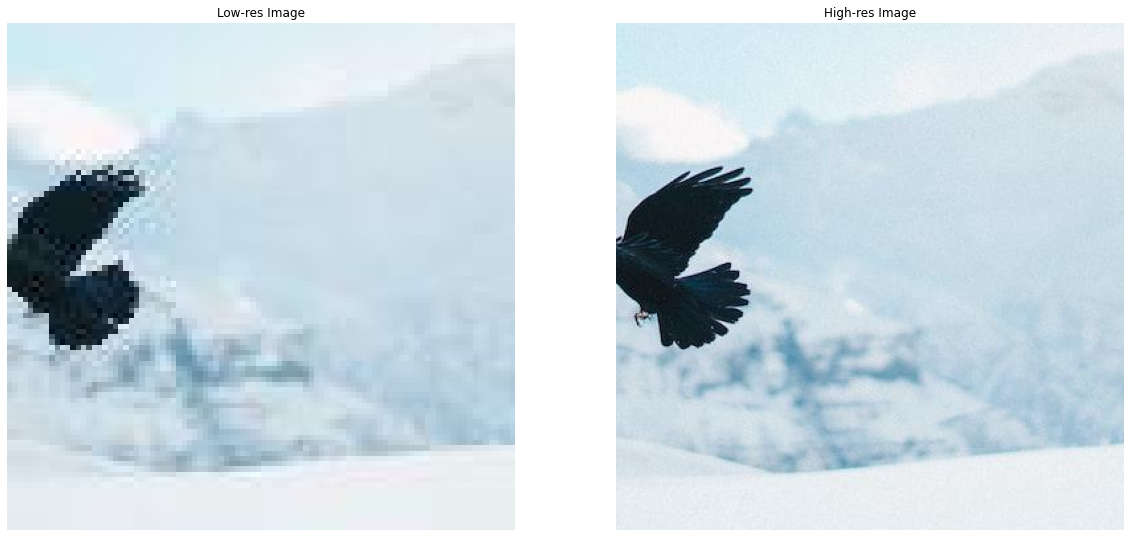

In [10]:
# Display the single sample image
show_tensorpair(img_dataset[20])

In [11]:
# Residual block for SRGAN generator
# Residual block configuration includes convolution layers with 64 out channels with 3x3 kernel, stride 1 and padding 1
# k3n64s1 Residual blocks
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Element wise summation using skip connections
        out += residual
        return out

In [12]:
# Implement the SRGAN generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        
        # Defining B number of residual blocks. We are taking B = 5
        self.residual_blocks = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )
        
        # k3n64s1 : 3x3 kernel with 64 channels and stride=1
        self.conv_layers = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        
        # Pixel shuffle layer for upsampling : k3n256s1
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            # k9n3s1 - last convolution layer
            nn.Conv2d(64, 3, kernel_size=9, padding=4)
        )

    def forward(self, x):
        out = self.init_layer(x)
        residual = out
        out = self.residual_blocks(out)
        out = self.conv_layers(out)
        # Implemented rlement wise summation through skip connections
        out += residual
        out = self.upsample(out)
        return torch.tanh(out)

In [13]:
# Define the SRGAN discriminator according to the base paper
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # k3n64s1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # k3n64s2
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # k3n128s1
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # k3n128s2
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # k3n256s1
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # k3n256s2
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # k3n512s1
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # k3n512s2
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # dense and leaky ReLU layers
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        x = torch.sigmoid(self.model(x))
        return x.view(x.size(0), -1)

In [14]:
# Function to extract features from pre-trained VGG19 model
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=35):
        super(VGGFeatureExtractor, self).__init__()
        vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:feature_layer]).to(device)
    
    def forward(self, x):
        return self.feature_extractor(x)

In [15]:
# Function to calculate peak signal-to-noise ratio
def calculate_psnr(img1, img2):
    # calculate MSE loss first
    mse = F.mse_loss(img1, img2)

    # if both images are same: mse will be zero
    if mse == 0:
        return float('inf')
    
    #psnr calculation formula = 20 * log10(R/sqrt(MSE)) where R is maximum pizel since we are dealing in float = it is 1.0
    max_pixel = 1.0
    return 20 * math.log10(max_pixel / math.sqrt(mse.item()))

In [16]:
# Function to calculate structural similarity index
def calculate_ssim(img1, img2):

    # initialize required value to store ssim avlues for each image
    ssim_values = []
    batch_size= img1.shape[0]
    

    # iterate over each image in the batch
    for i in range(batch_size):

        # average SSIM values across channels
        opimg = np.transpose(img1[i].cpu().numpy(), (1, 2, 0))
        ogimg = np.transpose(img2[i].cpu().numpy(), (1, 2, 0))

        ssim_val = ssim(opimg, ogimg, channel_axis=-1, data_range=ogimg.max() - ogimg.min())
        # take mean of all channels as ssim value for the image
        ssim_values.append(np.mean(ssim_val))

    # if there are any nan values then make it 0.0
    ssim_values = [0.0 if np.isnan(x) else x for x in ssim_values]

    if np.isnan(np.mean(ssim_values)):
        print(ssim_values)

    # return avrage of all images in the batch and return it as ssim value of all images in the batch
    return np.mean(ssim_values)

In [17]:
# function to evaluate the model on validation set
def validate_model(generator, val_loader, device):
    generator.eval()
    psnr = 0.0
    ssim_val = 0.0
    with torch.no_grad():
        for i, (lr_imgs, hr_imgs) in enumerate(tqdm(val_loader, desc="Validating...")):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            gen_hr = generator(lr_imgs)
            
            # Accumulate psnr for each batch
            psnr += calculate_psnr(gen_hr, hr_imgs)
            # Accumulate ssim for each batch
            ssim_val += calculate_ssim(gen_hr, hr_imgs)
            

            del lr_imgs, hr_imgs, gen_hr
            free_cuda_memory()
    # Calculate average psnr for the entire validation set
    psnr = psnr / len(val_loader)
    # Calculate average ssim for the entire validation set
    ssim_val = ssim_val / len(val_loader)
    
    return psnr, ssim_val

In [18]:
# Define the loss functions
adversarial_loss = nn.BCELoss().to(device)
pixelwise_loss = nn.MSELoss().to(device)
vgg_loss = VGGFeatureExtractor().eval()

In [19]:
# Initialize generator, discriminator and vgg features
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [26]:
save_dir = 'srgan_neptune_model_weights'
gen_path = os.path.join(save_dir, f'generator_epoch.pth')
disc_path = os.path.join(save_dir, f'discriminator_epoch.pth')

In [27]:
# generator.load_state_dict(torch.load(gen_path))
# discriminator.load_state_dict(torch.load(disc_path))

<All keys matched successfully>

In [21]:
learning_rate = 0.0001
epsi = 1e-8
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, eps=epsi)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, eps=epsi)

In [24]:
# Logging the parameters for neptuneai
params = {"learning_rate": learning_rate, "optimizer": "Adam", "Cropped image": True, "Crop specs": "Center, 96-96", "Epsilon":epsi}
run["parameters"] = params

In [22]:
# Directory to save model weights
save_dir = 'srgan_neptune_model_weights'
os.makedirs(save_dir, exist_ok=True)

# Function to save model weights
def save_weights(epoch, generator, discriminator, save_dir, log = False):
    if log == True:
        gen_path = os.path.join(save_dir, f'generator_epoch.pth')
        disc_path = os.path.join(save_dir, f'discriminator_epoch.pth')
    else:
        gen_path = os.path.join(save_dir, f'generator_epoch_{epoch}.pth')
        disc_path = os.path.join(save_dir, f'discriminator_epoch_{epoch}.pth')
    
    torch.save(generator.state_dict(), gen_path)
    
    torch.save(discriminator.state_dict(), disc_path)

In [23]:
# Load the training metrics from previous epochs for graph visualization, if necessary
# with open('srgan_sgd_neptune_losses.pkl', 'rb') as f:
#     losses = pickle.load(f)
#     g_losses = losses['g_losses']
#     d_losses = losses['d_losses']
#     content_loss = losses['content_loss']
#     psnr_values = losses['psnr_values']
#     ssim_values = losses['ssim_values']


In [32]:
num_epochs = 20

In [26]:
# d_losses = []
# g_losses = []
# content_loss = []
# psnr_values = []
# ssim_values = []

In [31]:
old_epoch = len(g_losses)
print(old_epoch)

70


In [32]:
old_epoch = len(g_losses)

for epoch in range(num_epochs):
    epoch_loss_G = 0.0
    epoch_loss_D = 0.0
    epoch_content_loss = 0.0
    for i, (lr_imgs, hr_imgs) in enumerate(tqdm(train_loader, desc=f"Epoch {old_epoch+epoch+1}/{old_epoch+num_epochs}")):
        # Create tensors of ones and zeroes of length equal to batch size
        valid = torch.ones((lr_imgs.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((lr_imgs.size(0), 1), requires_grad=False).to(device)
        # Push the input images and target images to CUDA
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        
        optimizer_G.zero_grad()

        # Generate a high-resolution image from low-resolution input
        gen_hr = generator(lr_imgs)
        # Calculate Generator loss
        loss_GAN = adversarial_loss(discriminator(gen_hr), valid)
        # Calculate pixel loss by comparing the features of generated image with vgg19 features
        loss_content = pixelwise_loss(vgg_loss(gen_hr), vgg_loss(hr_imgs))
        # Calculate pixel loss by comparing the generated image with high res image
        loss_pixel = pixelwise_loss(gen_hr, hr_imgs)
        epoch_content_loss+=loss_content

        # Calculate the total loss. Note that we prioritize pixel loss for iamge superresolution task
        loss_G = loss_pixel + 0.001 * loss_GAN + 0.006 * loss_content
        loss_G.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()

        # Calculate discriminator loss for real images
        loss_real = adversarial_loss(discriminator(hr_imgs), valid)
        loss_fake = adversarial_loss(discriminator(gen_hr.detach()), fake)
        
        # Calcualte total discriminator loss by taking average of real loss and fake loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()
        
        # Accumulate the losses accross all batches
        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()
    
    # Take the average losses for the epoch
    avg_content_loss = epoch_content_loss / len(train_loader)
    avg_loss_G = epoch_loss_G / len(train_loader)
    avg_loss_D = epoch_loss_D / len(train_loader)
    
    # Append to lists
    d_losses.append(avg_loss_D)
    g_losses.append(avg_loss_G)
    content_loss.append(avg_content_loss.cpu().item())
    
    free_cuda_memory()
    
    save_weights(old_epoch+num_epochs,generator, discriminator, save_dir, log=True)
        
    print(f"Epoch {old_epoch+epoch+1} completed: D loss: {avg_loss_D}, G loss: {avg_loss_G}, Content loss: {avg_content_loss}")
    
    epoch_psnr, epoch_ssim = validate_model(generator, val_loader, device)
    psnr_values.append(epoch_psnr)
    ssim_values.append(epoch_ssim)
    
    # Log the metrics to neptune.ai
    run["train/disc_loss"].append(avg_loss_D)
    run["train/gen_loss"].append(avg_loss_G)
    run["train/content_loss"].append(avg_content_loss)
    run["val/psnr"].append(epoch_psnr)
    run["val/ssim"].append(epoch_ssim)
    
    print(f"Validation Epoch {old_epoch+epoch+1} completed: PSNR: {epoch_psnr}, SSIM: {epoch_ssim}")
    
    # Storing the training metrics into pkl file for later usage
    with open('srgan_sgd_neptune_losses.pkl', 'wb') as file:
        pickle.dump({'g_losses': g_losses,
                     'd_losses': d_losses,
                     'content_loss': content_loss,
                     'psnr_values':psnr_values,
                     'ssim_values':ssim_values}, file)

save_weights(old_epoch+num_epochs,generator, discriminator, save_dir)

Epoch 51/70: 100%|██████████| 878/878 [03:43<00:00,  3.93it/s]


Epoch 51 completed: D loss: 0.015553397317164461, G loss: 0.0245204102067629, Content loss: 1.5004276037216187


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.00it/s]


Validation Epoch 51 completed: PSNR: 22.81065862038305, SSIM: 0.5942439395696559


Epoch 52/70: 100%|██████████| 878/878 [03:34<00:00,  4.10it/s]


Epoch 52 completed: D loss: 0.10774108023427813, G loss: 0.01964078432400891, Content loss: 1.2468293905258179


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.07it/s]


Validation Epoch 52 completed: PSNR: 24.06051637224269, SSIM: 0.6619518787619916


Epoch 53/70: 100%|██████████| 878/878 [03:34<00:00,  4.10it/s]


Epoch 53 completed: D loss: 0.1067290979998707, G loss: 0.01730530687283241, Content loss: 1.166589379310608


Validating...: 100%|██████████| 188/188 [00:36<00:00,  5.09it/s]


Validation Epoch 53 completed: PSNR: 23.73057334826244, SSIM: 0.6393453721353348


Epoch 54/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 54 completed: D loss: 0.11121958698506561, G loss: 0.017366469234168732, Content loss: 1.1801527738571167


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.05it/s]


Validation Epoch 54 completed: PSNR: 22.885570996579837, SSIM: 0.5881584151945216


Epoch 55/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 55 completed: D loss: 0.10588845919157314, G loss: 0.01746257677237272, Content loss: 1.1733204126358032


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.08it/s]


Validation Epoch 55 completed: PSNR: 23.97754664652317, SSIM: 0.6459713930145223


Epoch 56/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 56 completed: D loss: 0.11031777889636067, G loss: 0.01722263640900204, Content loss: 1.158362865447998


Validating...: 100%|██████████| 188/188 [00:36<00:00,  5.11it/s]


Validation Epoch 56 completed: PSNR: 23.754188546540234, SSIM: 0.6426567661952465


Epoch 57/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 57 completed: D loss: 0.10150439748544995, G loss: 0.017548786431703725, Content loss: 1.1600430011749268


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.07it/s]


Validation Epoch 57 completed: PSNR: 23.333543310450082, SSIM: 0.6271499571331004


Epoch 58/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 58 completed: D loss: 0.13101295813648156, G loss: 0.01678368069203931, Content loss: 1.1426619291305542


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.05it/s]


Validation Epoch 58 completed: PSNR: 23.569081809069093, SSIM: 0.641457957314684


Epoch 59/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 59 completed: D loss: 0.09721140243509954, G loss: 0.017396782194996137, Content loss: 1.1414544582366943


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.06it/s]


Validation Epoch 59 completed: PSNR: 23.673763913012685, SSIM: 0.6461566803937263


Epoch 60/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 60 completed: D loss: 0.10331068845807169, G loss: 0.017614118819568383, Content loss: 1.158223271369934


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.06it/s]


Validation Epoch 60 completed: PSNR: 24.028580656671156, SSIM: 0.6474337750609885


Epoch 61/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 61 completed: D loss: 0.08998548660217108, G loss: 0.017541576985689835, Content loss: 1.1464877128601074


Validating...: 100%|██████████| 188/188 [00:36<00:00,  5.11it/s]


Validation Epoch 61 completed: PSNR: 23.05886971823607, SSIM: 0.6198782546723143


Epoch 62/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 62 completed: D loss: 0.0982486893364263, G loss: 0.01767711405608387, Content loss: 1.1521474123001099


Validating...: 100%|██████████| 188/188 [00:36<00:00,  5.10it/s]


Validation Epoch 62 completed: PSNR: 24.054187212859542, SSIM: 0.6557781035278706


Epoch 63/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 63 completed: D loss: 0.09100405721706623, G loss: 0.017169526226580956, Content loss: 1.1483935117721558


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.07it/s]


Validation Epoch 63 completed: PSNR: 23.619337024924473, SSIM: 0.6337629886383706


Epoch 64/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 64 completed: D loss: 0.10733610719837093, G loss: 0.017167162974333235, Content loss: 1.150763750076294


Validating...: 100%|██████████| 188/188 [00:36<00:00,  5.09it/s]


Validation Epoch 64 completed: PSNR: 23.987881156998103, SSIM: 0.6445789700175854


Epoch 65/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 65 completed: D loss: 0.08987331234305768, G loss: 0.018032185570495986, Content loss: 1.1978299617767334


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.05it/s]


Validation Epoch 65 completed: PSNR: 23.93840952736652, SSIM: 0.6526522955044787


Epoch 66/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 66 completed: D loss: 0.11142495569625278, G loss: 0.017239592631574475, Content loss: 1.1443381309509277


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.07it/s]


Validation Epoch 66 completed: PSNR: 22.91805711055996, SSIM: 0.62355510208835


Epoch 67/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 67 completed: D loss: 0.0857908388010119, G loss: 0.017521641636691596, Content loss: 1.14453125


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.07it/s]


Validation Epoch 67 completed: PSNR: 23.159471858549132, SSIM: 0.627663310379424


Epoch 68/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 68 completed: D loss: 0.09101823676400705, G loss: 0.01720815151611636, Content loss: 1.119000792503357


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.07it/s]


Validation Epoch 68 completed: PSNR: 23.99908327339678, SSIM: 0.6484517367913368


Epoch 69/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 69 completed: D loss: 0.09975690213079966, G loss: 0.01681297158574206, Content loss: 1.1233071088790894


Validating...: 100%|██████████| 188/188 [00:36<00:00,  5.12it/s]


Validation Epoch 69 completed: PSNR: 23.877884337235344, SSIM: 0.6556616566599683


Epoch 70/70: 100%|██████████| 878/878 [03:34<00:00,  4.09it/s]


Epoch 70 completed: D loss: 0.0856435980242752, G loss: 0.016972832735479386, Content loss: 1.1121535301208496


Validating...: 100%|██████████| 188/188 [00:37<00:00,  5.07it/s]

Validation Epoch 70 completed: PSNR: 24.021859427788232, SSIM: 0.6569784302660759


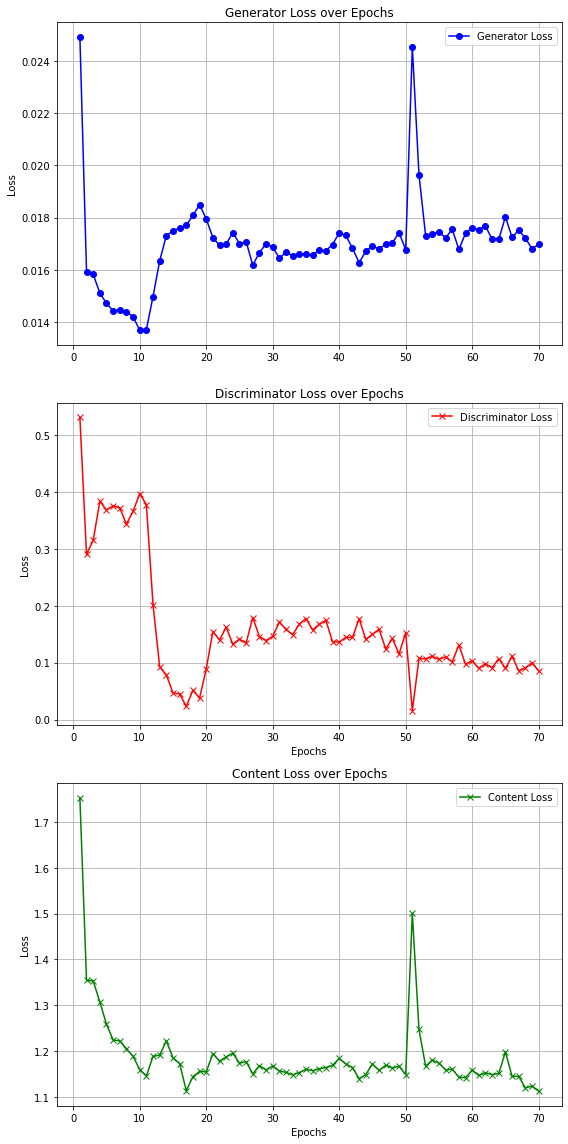

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 16), sharex=False)
total_epochs = len(g_losses)
# Plotting generator Loss vs epoch
ax1.plot(range(1, total_epochs + 1), g_losses, label='Generator Loss', marker='o', color='b')
ax1.set_title('Generator Loss over Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plotting discriminator Loss vs epoch
ax2.plot(range(1, total_epochs + 1), d_losses, label='Discriminator Loss', marker='x', color='r')
ax2.set_title('Discriminator Loss over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.legend()

# Plotting content Loss vs epoch
ax3.plot(range(1, total_epochs + 1), content_loss, label='Content Loss', marker='x', color='g')
ax3.set_title('Content Loss over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

In [28]:
# Function to evaluate the model on test set
def test_model(generator, test_loader, img_cnt=5):
    generator.eval()
    psnr = 0.0
    ssim_val = 0.0
    count = 0
    with torch.no_grad():
        for i, (lr_imgs, hr_imgs) in enumerate(tqdm(test_loader, desc="Testing")):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            gen_hr = generator(lr_imgs)
            # Accumulate the psnr and ssim values over each batch
            psnr += calculate_psnr(gen_hr, hr_imgs)
            ssim_val += calculate_ssim(gen_hr, hr_imgs)
            if count < img_cnt:
                count += 1
                display_compare_images(lr_imgs, hr_imgs, gen_hr)
            del lr_imgs, hr_imgs, gen_hr
            free_cuda_memory()
    # Calculate the psnr and ssim values for each epoch
    psnr = psnr / len(test_loader)
    ssim_val = ssim_val/len(test_loader)
    print(f'PSNR value for testing dataset is : {psnr}')
    print(f'SSIM value for testing dataset is : {ssim_val}')

In [29]:
def display_compare_images(lr, hr, op):
    itr = lr.size(0)
    fig, ax = plt.subplots(3, itr, figsize=(20, 12))
    if itr == 1:
        ax[0].imshow(lr[0].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Low res image")
        ax[0].axis('off')
        ax[1].imshow(hr[0].permute(1, 2, 0).cpu().numpy())
        ax[1].set_title("High res image")
        ax[1].axis('off')
        ax[2].imshow(op[0].permute(1, 2, 0).cpu().numpy())
        ax[2].set_title("Super resolved image")
        ax[2].axis('off')
    else:
        for i in range(itr):
            lrimg = lr[i].permute(1, 2, 0).cpu().numpy()
            hrimg = hr[i].permute(1, 2, 0).cpu().numpy()
            opimg = op[i].permute(1, 2, 0).cpu().numpy()
            ax[0, i].imshow(lrimg)
            ax[0, i].set_title("Low res image")
            ax[0, i].axis('off')
            ax[1, i].imshow(hrimg)
            ax[1, i].set_title("High res image")
            ax[1, i].axis('off')
            ax[2, i].imshow(opimg)
            ax[2, i].set_title("Super resolved image")
            ax[2, i].axis('off')
    plt.tight_layout()
    plt.show()

Testing:   0%|          | 0/189 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


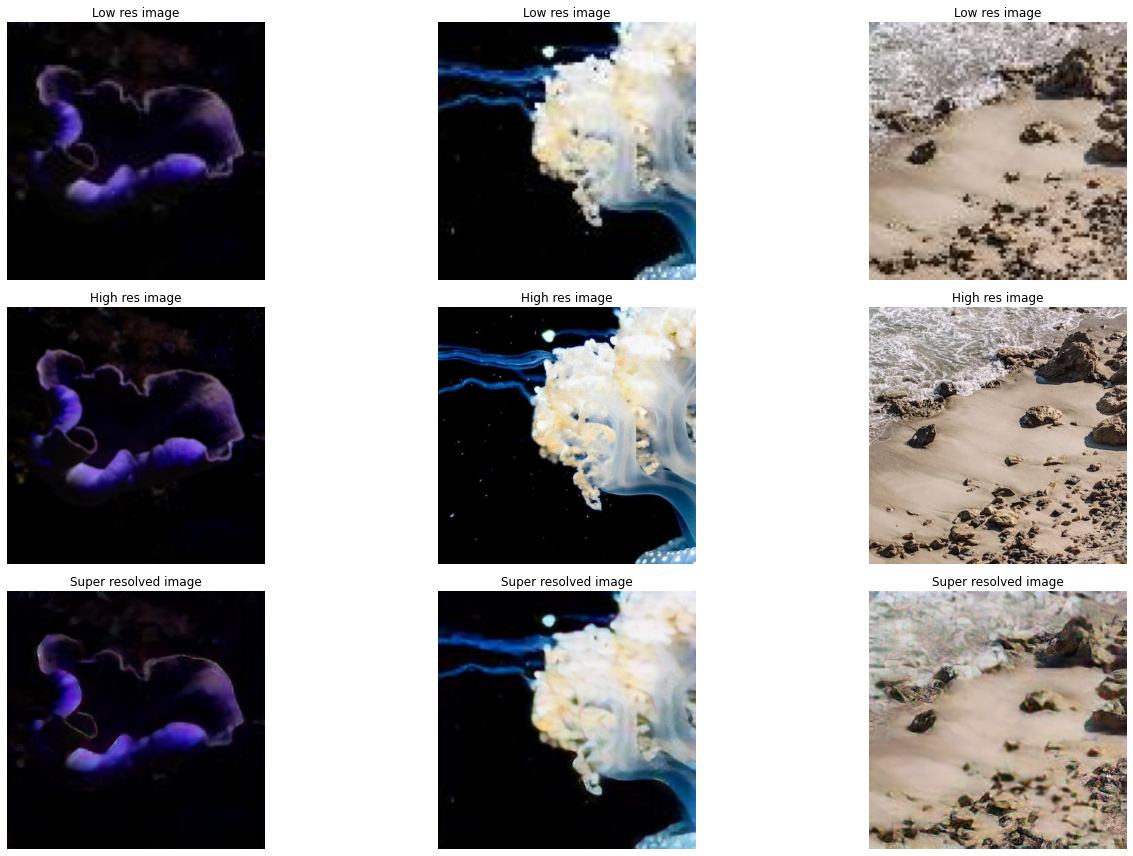

Testing:   1%|          | 1/189 [00:09<29:14,  9.33s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


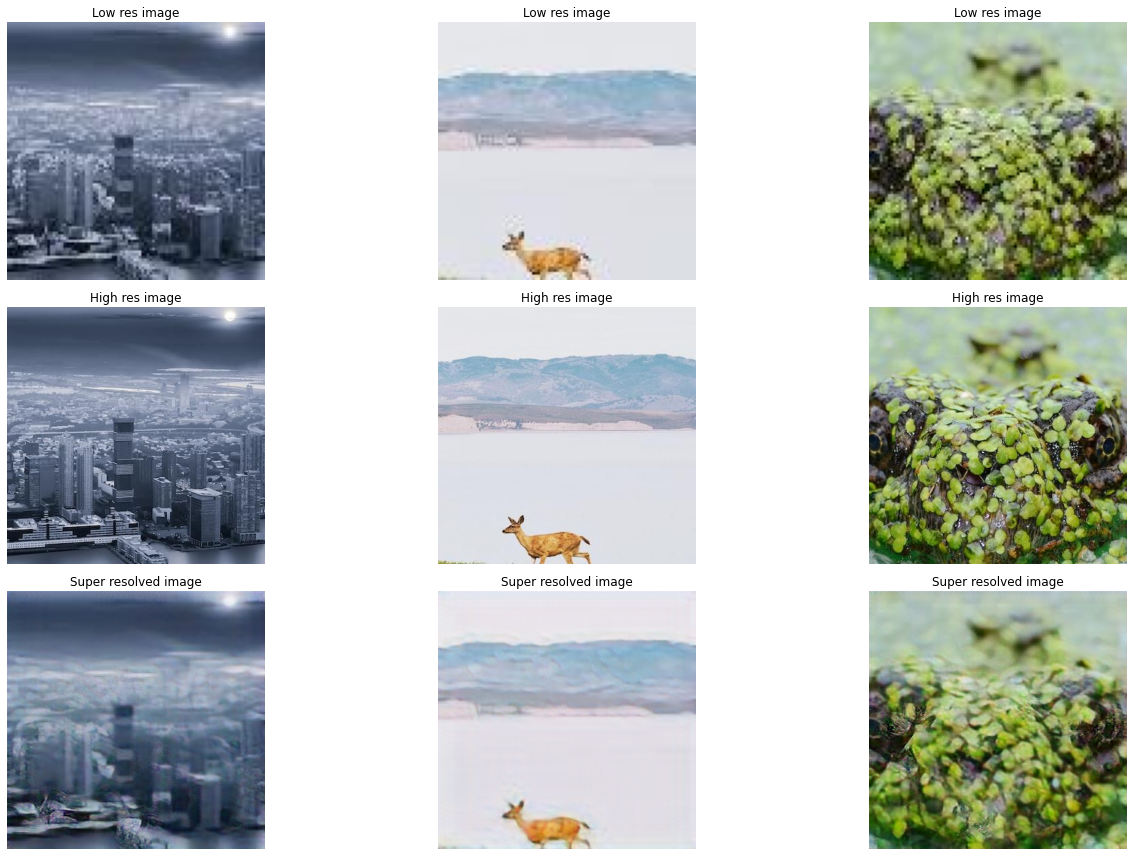

Testing:   1%|          | 2/189 [00:10<14:00,  4.50s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


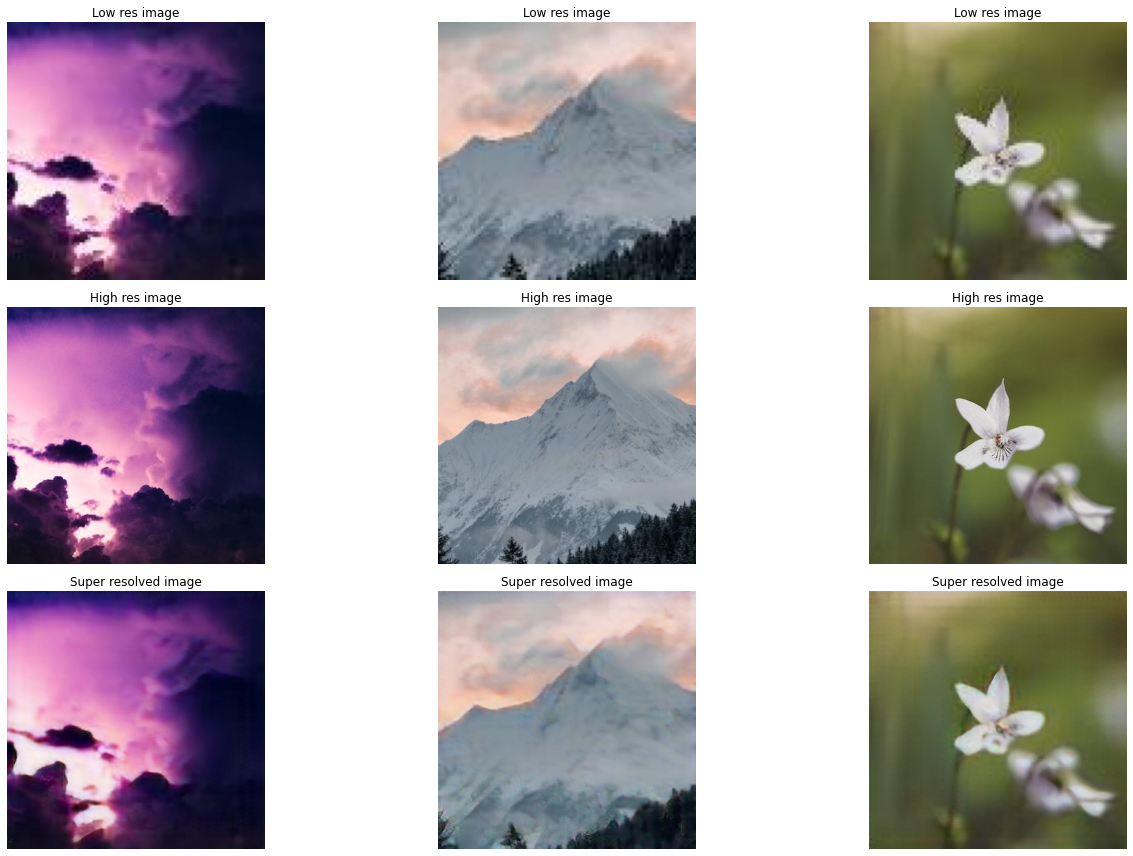

Testing:   2%|▏         | 3/189 [00:11<09:11,  2.97s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


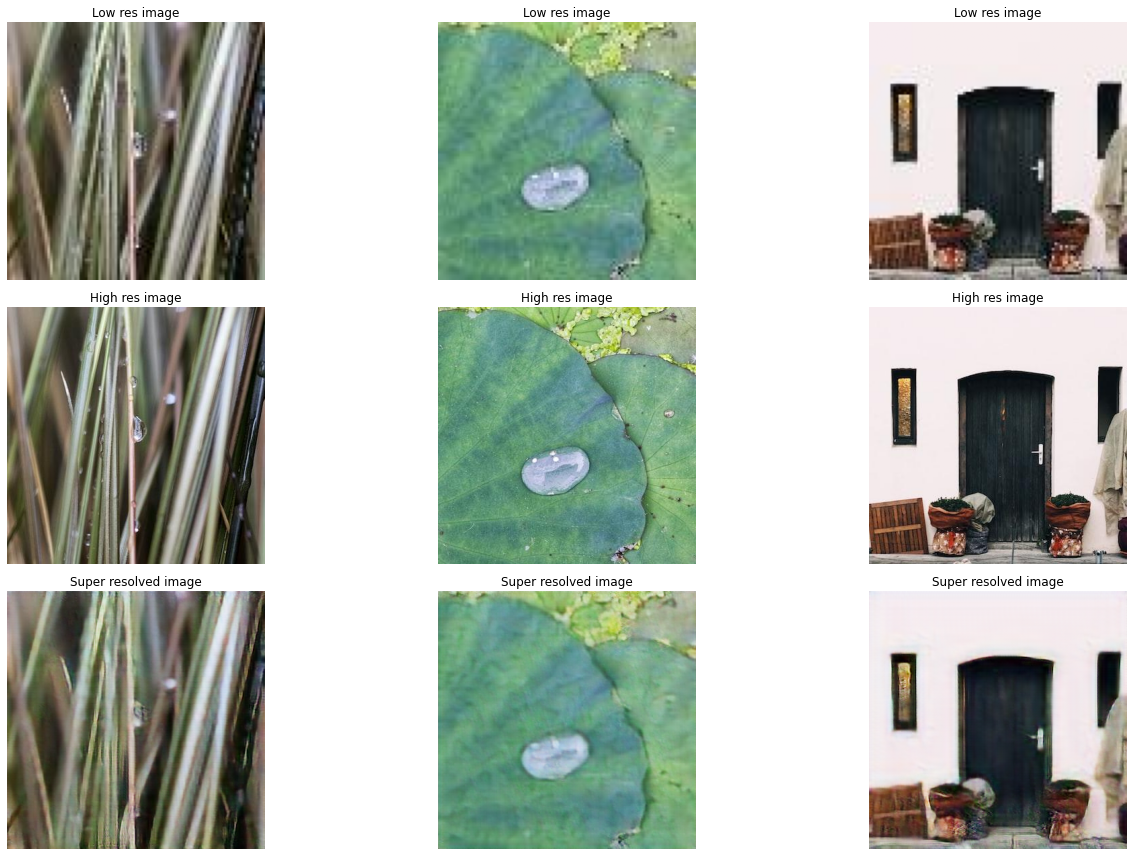

Testing:   2%|▏         | 4/189 [00:12<07:02,  2.28s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


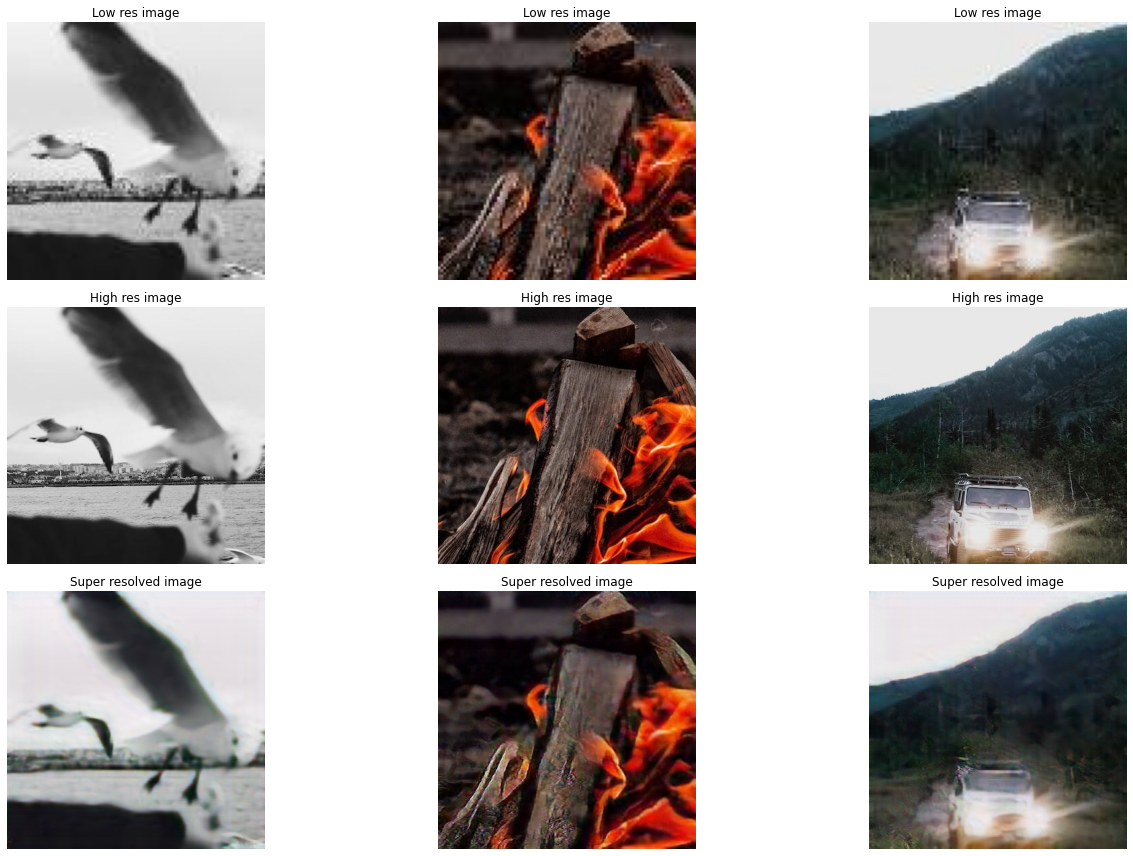

Testing: 100%|██████████| 189/189 [00:52<00:00,  3.63it/s]

PSNR value for testing dataset is : 24.497461512186963
SSIM value for testing dataset is : 0.6734113563936224


In [30]:
test_model(generator, test_loader)

In [43]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/ImgResProject/ImageRes/e/FSRCNN-33/metadata


## References

<ul>
    <li>https://github.com/brade31919/SRGAN-tensorflow/tree/master</li>
    <li>https://github.com/tensorlayer/SRGAN/blob/master/srgan.py</li>
</ul>